# Banka İçin Fraud Detection Projesi
Bu notebook, kredi kartı işlemleri üzerinde sahte (fraud) işlemleri tespit etmek için geliştirdiğimiz makine öğrenmesi modelini içermektedir.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install xgboost


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix
)

%matplotlib inline


## 1. Veri Yükleme ve İlk İnceleme

In [5]:
# Veri setini yüklediğimiz yer
df = pd.read_csv("/content/drive/MyDrive/fraud_project/creditcard.csv")

print("\nVeri şekli (satır, sütun):", df.shape)


Veri şekli (satır, sütun): (284807, 31)


## 2. Veri Analizi ve Sınıf Dağılımı

In [6]:

print("öznitelikler:")
print(df.columns)

# Sınıf dağılımı
print("\nSınıf (Class) dağılımı:")
print(df["Class"].value_counts())


öznitelikler:
Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

Sınıf (Class) dağılımı:
Class
0    284315
1       492
Name: count, dtype: int64


## 3. Veri Ön İşleme (Eksik Veriler ve Temizleme)

In [7]:
# Eksik değer kontrolü , eğer varsa eksik değer içeren verileri silelim
print("Eksik değer sayıları:")
print(df.isnull().sum())
df = df.dropna()

print("\nTemizlendikten sonra veri boyutu:", df.shape)
print("\nYeni Class dağılımı:")
print(df["Class"].value_counts())

Eksik değer sayıları:
Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

Temizlendikten sonra veri boyutu: (284807, 31)

Yeni Class dağılımı:
Class
0    284315
1       492
Name: count, dtype: int64


## 4. Train-Test Ayrımı ve Özellik Ölçekleme

In [8]:
# x (girdi)'den ana hedefi çıkarıyoruz ve y (çıktı)'ya ana hedefi atıyoruz
X = df.drop("Class", axis=1)
y = df["Class"]

# Train / Test bölme %20 test % 80 train olacak şekilde ayırıyoruz
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train set boyutu:", X_train.shape)
print("Test set boyutu:", X_test.shape)

# Logistic Regression için ölçekleme
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Train set boyutu: (227845, 30)
Test set boyutu: (56962, 30)


## 5. Model 1 – Logistic Regression

In [9]:
# Logistic Regression modeli
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train_scaled, y_train)


y_pred_log = log_model.predict(X_test_scaled)

print(" LOGISTIC REGRESSION SONUÇLARI ")
print(classification_report(y_test, y_pred_log, digits=4))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_log))

 LOGISTIC REGRESSION SONUÇLARI 
              precision    recall  f1-score   support

           0     0.9994    0.9998    0.9996     56864
           1     0.8267    0.6327    0.7168        98

    accuracy                         0.9991     56962
   macro avg     0.9130    0.8162    0.8582     56962
weighted avg     0.9991    0.9991    0.9991     56962

Confusion Matrix:
[[56851    13]
 [   36    62]]


## 6. Model 2 – Random Forest

In [10]:
# Random Forest modeli
rf_model = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

print(" RANDOM FOREST SONUÇLARI ")
print(classification_report(y_test, y_pred_rf, digits=4))
print("Confusion Matrix:")
cm_rf = confusion_matrix(y_test, y_pred_rf)
print(cm_rf)

 RANDOM FOREST SONUÇLARI 
              precision    recall  f1-score   support

           0     0.9997    0.9999    0.9998     56864
           1     0.9419    0.8265    0.8804        98

    accuracy                         0.9996     56962
   macro avg     0.9708    0.9132    0.9401     56962
weighted avg     0.9996    0.9996    0.9996     56962

Confusion Matrix:
[[56859     5]
 [   17    81]]


## 7. Model 3 – XGBoost


In [11]:
# Class imbalance için ağırlık oranı (normal / fraud)
scale_pos = y_train.value_counts()[0] / y_train.value_counts()[1]
print("scale_pos_weight:", scale_pos)

xgb_model = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos,
    random_state=42,
    eval_metric="logloss",
    n_jobs=-1
)

xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)

print("\n==== XGBOOST SONUÇLARI ====")
print(classification_report(y_test, y_pred_xgb, digits=4))

cm_xgb = confusion_matrix(y_test, y_pred_xgb)
print("Confusion Matrix:")
print(cm_xgb)

scale_pos_weight: 577.2868020304569

==== XGBOOST SONUÇLARI ====
              precision    recall  f1-score   support

           0     0.9997    0.9998    0.9997     56864
           1     0.8542    0.8367    0.8454        98

    accuracy                         0.9995     56962
   macro avg     0.9269    0.9182    0.9225     56962
weighted avg     0.9995    0.9995    0.9995     56962

Confusion Matrix:
[[56850    14]
 [   16    82]]


## 8. PR-AUC Performance Analysis


PR-AUC (XGBoost): 0.8763


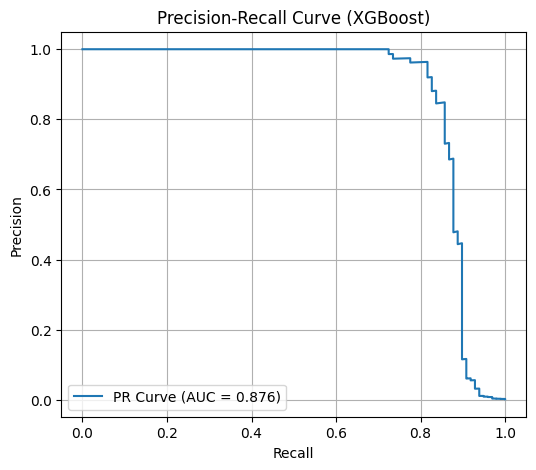

In [12]:
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

# XGBoost fraud olasılıkları
y_scores = xgb_model.predict_proba(X_test)[:, 1]

# Precision-Recall hesapla
precision, recall, _ = precision_recall_curve(y_test, y_scores)
pr_auc = auc(recall, precision)

print(f"PR-AUC (XGBoost): {pr_auc:.4f}")

# PR eğrisi
plt.figure(figsize=(6,5))
plt.plot(recall, precision, label=f"PR Curve (AUC = {pr_auc:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (XGBoost)")
plt.legend()
plt.grid(True)
plt.show()
